**Update 8/23<br/>**
Since the propensity in treated group shows extremely bimodal distribution, it's hard to get the proper matching result. <br/>

The next step could be considered on 3 aspects. <br/>
1.Use oversampling/stratification to deal with the imbalanced data <br/>
2.Recheck the causal relationship between variables <br/>
3.Re-defined the problem 

## Problem Definition: Causal Graph

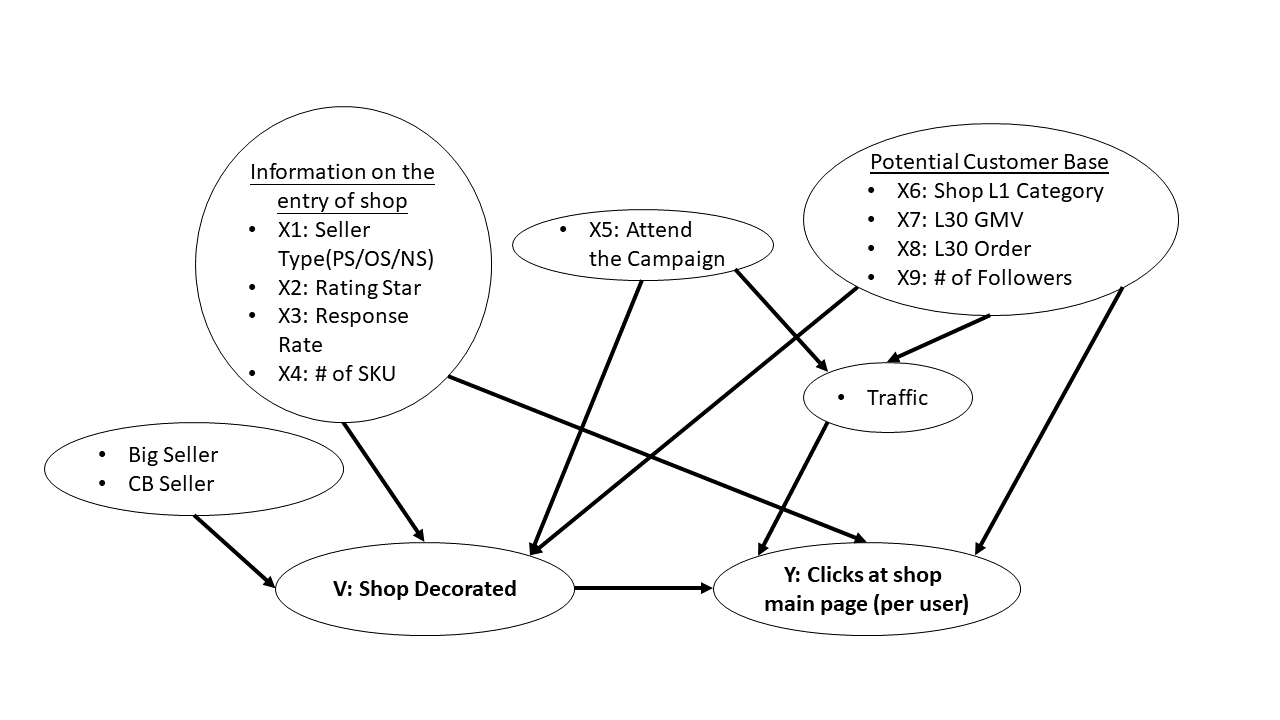

In [227]:
from IPython.display import Image, display
display(Image(filename="graph/causalGraph_v0823.png"))

## Step0. Package/Variable Setting

In [201]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from patsy import dmatrices
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, Normalizer
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

##  Step1. Estimation of Propensity Score

### 1-1. Data Processing

In [3]:
trn_df = pd.read_csv('data/MY_shopProfiling+Effects.csv', sep = ',')
tst_df = pd.read_csv('data/ID_shopProfiling.csv', sep = ',')

In [4]:
print(trn_df.shape, tst_df.shape)
trn_df.head(2)

(35588, 13) (128285, 11)


,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,4.90,89,745,N,Muslim Fashion,3202.70,51,264.0,0,0.0,2.5
1,439807,NS,4.17,65,9,N,Groceries & Pets,329.04,6,101.0,0,0.0,0.0


In [5]:
# Check the null values
pd.DataFrame(data = [trn_df.isnull().sum(), tst_df.isnull().sum()], index=['trn_df','tst_df']).T

,trn_df,tst_df
shopid,0.0,0.0
seller_type,0.0,0.0
rating_star,0.0,0.0
display_response_rate,0.0,0.0
sku,0.0,0.0
camp_flag,0.0,0.0
main_category,0.0,0.0
p30_gmv,0.0,0.0
p30_order_cnt,0.0,0.0
follower_count,38.0,0.0


In [6]:
trn_df.follower_count.fillna(value = 0, inplace = True)

In [7]:
# Check
# pd.DataFrame(data = [trn_df.isnull().sum(), tst_df.isnull().sum()], index=['trn_df','tst_df']).T

In [7]:
trn_df.dtypes

shopid                      int64
seller_type                object
rating_star               float64
display_response_rate       int64
sku                         int64
camp_flag                  object
main_category              object
p30_gmv                   float64
p30_order_cnt               int64
follower_count            float64
Decorated                   int64
Clicks_pre_User_Before    float64
Clicks_pre_User_After     float64
dtype: object

In [8]:
# shop_profile.columns.values
num_cols = [n for n in trn_df.columns if is_numeric_dtype(trn_df[n])]
str_cols = [n for n in trn_df.columns if is_string_dtype(trn_df[n])]

# Drop main category due to difference of categories between MY and ID
drop_cols = ['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After', 'main_category']
y_cols = ['Decorated']

In [9]:
trn_df.head(2)

,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,4.90,89,745,N,Muslim Fashion,3202.70,51,264.0,0,0.0,2.5
1,439807,NS,4.17,65,9,N,Groceries & Pets,329.04,6,101.0,0,0.0,0.0


In [16]:
# trn_df.rating_star.hist()

In [17]:
# Standardize the numeric variables
map_f = [([n],StandardScaler()) for n in trn_df.drop(columns = str_cols + y_cols + drop_cols).columns]
# map_f
mapper = DataFrameMapper(map_f).fit(trn_df)
trn_df_scaled = trn_df.copy()
trn_df_scaled[mapper.transformed_names_] = mapper.transform(trn_df)

/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversion

In [15]:
# trn_df_scaled.rating_star.hist()

In [18]:
trn_df_scaled.head(2)

,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,0.412848,0.340051,0.301299,N,Muslim Fashion,-0.148874,-0.162638,-0.269229,0,0.0,2.5
1,439807,NS,-4.337566,-1.812548,-0.403096,N,Groceries & Pets,-0.244146,-0.261135,-0.315220,0,0.0,0.0


Concept of StandardScaler: After transformed, the average of features is 0 and std is 1.

In [19]:
# Transform the category variables to dummy variables
print('drop the following columns:', drop_cols)
for_model_df = pd.get_dummies(trn_df_scaled.drop(columns = drop_cols))

drop the following columns: ['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After', 'main_category']


In [20]:
print(for_model_df.shape)
for_model_df.head(2)

(35588, 12)


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0
1,-4.337566,-1.812548,-0.403096,-0.244146,-0.261135,-0.315220,0,1,0,0,1,0


### 1-2. Modeling

In [21]:
X, y = for_model_df.drop(columns = y_cols), for_model_df[y_cols]

#### 1-2-1. Logistic Regression

In [22]:
lor = linear_model.LogisticRegression()
lor.fit(X, y)

/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
lor.predict_proba(X)[:,1]

array([0.01685413, 0.00576935, 0.01962342, ..., 0.01799453, 0.01419868,
       0.01023979])

In [24]:
print(lor.intercept_)
pd.DataFrame(data = [X.columns.values, lor.coef_[0]]).T

[0.21312768]


,0,1
0,rating_star,0.117954
1,display_response_rate,0.313364
2,sku,-0.167141
3,p30_gmv,-0.00558245
4,p30_order_cnt,-0.363279
5,follower_count,0.0525291
6,seller_type_NS,0.222823
7,seller_type_OS,0.02202
8,seller_type_PS,-0.0317153
9,camp_flag_N,-4.65278


In [25]:
# AUC
roc_auc_score(y, lor.predict_proba(X)[:,1])

0.8354485653386354

#### 1-2-2. Logit

<img src="graph/logit.svg" width = "500">

In [26]:
for_model_df.head(1)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0


In [27]:
# Create the Intercept for logit
_y, _X = dmatrices('Decorated ~ rating_star + display_response_rate + sku + p30_gmv + p30_order_cnt + follower_count + seller_type_NS + seller_type_OS + seller_type_PS + camp_flag_N + camp_flag_Y', 
                 for_model_df, return_type = 'dataframe')

In [28]:
logit = sm.Logit(_y,_X).fit(method='bfgs')

         Current function value: 0.076492
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/ericwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
logit.params

Intercept                0.018557
rating_star              0.141737
display_response_rate    0.314615
sku                     -0.196572
p30_gmv                 -0.131135
p30_order_cnt           -0.124562
follower_count           0.034715
seller_type_NS           0.456319
seller_type_OS          -0.043288
seller_type_PS          -0.394474
camp_flag_N             -4.647814
camp_flag_Y              4.666372
dtype: float64

In [30]:
roc_auc_score(_y, logit.predict(_X))

0.8321786774786808

### 1-3. Model assessment

#### 1-3-1. Data Processing for tst_df

In [31]:
# shop_profile.columns.values
num_cols = [n for n in tst_df.columns if is_numeric_dtype(tst_df[n])]
str_cols = [n for n in tst_df.columns if is_string_dtype(tst_df[n])]
# Drop main category due to difference of categories between MY and ID
drop_cols = ['shopid','main_category']
y_cols = ['Decorated']


# Standardize the numeric variables
map_f = [([n],StandardScaler()) for n in tst_df.drop(columns = str_cols + y_cols + drop_cols).columns]
# map_f
mapper = DataFrameMapper(map_f).fit(tst_df)
tst_df_scaled = tst_df.copy()
tst_df_scaled[mapper.transformed_names_] = mapper.transform(tst_df)


# Transform the category variables to dummy variables
print('drop the following columns:', drop_cols)
for_model_tst_df = pd.get_dummies(tst_df_scaled.drop(columns = drop_cols))

/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversion

drop the following columns: ['shopid', 'main_category']


In [32]:
print(for_model_tst_df.shape)
for_model_tst_df.head(2)

(128285, 12)


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.157007,0.048215,-0.340031,-0.147584,-0.162868,-0.183219,0,1,0,0,1,0
1,-2.740833,0.149147,-0.318322,-0.147676,-0.165574,-0.123038,0,1,0,0,1,0


#### 1-3-2. Assess the different models

Model-1. Logistic Regression

In [33]:
tst_X, tst_y = for_model_tst_df.drop(columns = y_cols), for_model_tst_df[y_cols]

In [34]:
model1_roc = roc_auc_score(tst_y, lor.predict_proba(tst_X)[:,1])
model1_roc

0.8735959762433259

In [35]:
print(confusion_matrix(tst_y, lor.predict(tst_X)))
print(classification_report(tst_y, lor.predict(tst_X)))

[[127069      0]
 [   347    869]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127069
           1       1.00      0.71      0.83      1216

   micro avg       1.00      1.00      1.00    128285
   macro avg       1.00      0.86      0.92    128285
weighted avg       1.00      1.00      1.00    128285



Model-2. Logit

In [36]:
# Create the Intercept for logit
tst_y, tst_X = dmatrices('Decorated ~ rating_star + display_response_rate + sku + p30_gmv + p30_order_cnt + follower_count + seller_type_NS + seller_type_OS + seller_type_PS + camp_flag_N + camp_flag_Y', 
                         for_model_tst_df, return_type = 'dataframe')

In [37]:
model2_roc = roc_auc_score(tst_y, logit.predict(tst_X))
model2_roc

0.8777105818181667

In [38]:
thresold = 0.5
predict = np.where(logit.predict(tst_X) > thresold, 1, 0)

In [39]:
print(confusion_matrix(tst_y, predict))
print(classification_report(tst_y, predict)) 

[[127069      0]
 [   345    871]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    127069
         1.0       1.00      0.72      0.83      1216

   micro avg       1.00      1.00      1.00    128285
   macro avg       1.00      0.86      0.92    128285
weighted avg       1.00      1.00      1.00    128285



### 1-4. Observe the propensity

In [40]:
for_model_df.head(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0
1,-4.337566,-1.812548,-0.403096,-0.244146,-0.261135,-0.315220,0,1,0,0,1,0


In [41]:
plot_df = for_model_df.copy()
plot_df['logit_score'] = logit.predict(_X)
# plot_df['logistic_score'] = lor.predict_proba(X)[:,1]

Text(0.5, 0.98, 'Probability of decorating the shop')

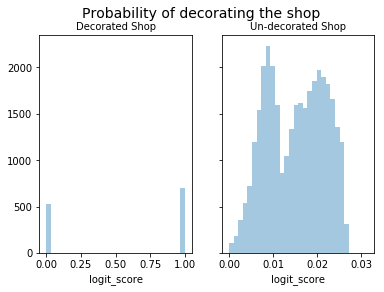

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.distplot(plot_df[plot_df.Decorated == 1]['logit_score'], bins= 30, kde=False, hist=True, ax= ax1)
sns.distplot(plot_df[plot_df.Decorated == 0]['logit_score'], bins= 30, kde=False, hist=True, ax= ax2)

ax1.set_title("Decorated Shop", fontsize=10)
ax2.set_title("Un-decorated Shop", fontsize=10)
fig.suptitle("Probability of decorating the shop", fontsize=14)

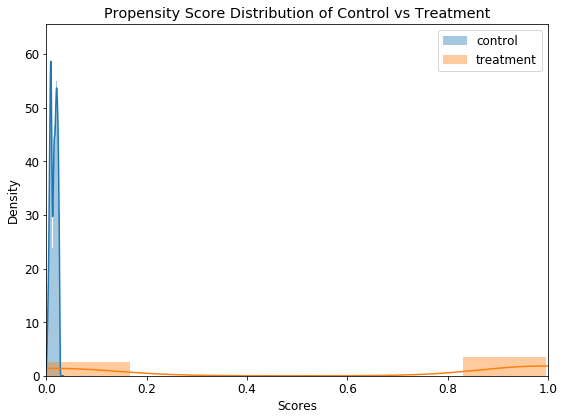

In [45]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(plot_df[plot_df.Decorated == 0]['logit_score'], label='control')
sns.distplot(plot_df[plot_df.Decorated == 1]['logit_score'], label='treatment')

plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

The propensity in treated group shows extremely bimodal distribution... <br/>
It's better to deal with the imbalanced problem or re-track the definition of data.

By the way, we could measure the degree of imbalance of covariances between treatment group and control group by standardised bias(as Type4-1)

## Step2. Choose Matching algorithm

### 2-1. Data Processing

In [55]:
# get the id and treatment effect
for_mth_df = pd.concat([plot_df.copy(), trn_df[['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After']]], axis = 1)
for_mth_df.shape

(35588, 16)

In [56]:
for_mth_df.tail(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
35586,-2.190118,0.519434,0.041936,-0.243186,-0.263324,-0.341178,0,1,0,0,1,0,0.013717,149256535,0.000000,2.2500
35587,0.933442,-1.812548,-0.395439,-0.164037,-0.149505,-0.338638,0,1,0,0,1,0,0.010935,150994626,1.434783,2.1875


In [57]:
for_mth_df_treated = for_mth_df.loc[for_mth_df['Decorated'] == 1]
for_mth_df_control = for_mth_df.loc[for_mth_df['Decorated'] == 0]

In [58]:
print(for_mth_df.shape, '=' ,for_mth_df_treated.shape, for_mth_df_control.shape)

(35588, 16) = (1242, 16) (34346, 16)


###  2-2. Modeling

Since the propensity score distribution is very different in treatment and group, <br/>
1. we could use matching with replacement to decrease the bias and increase the average quality of matching <br/>
2. Imposing a caliper works in the same direction as allowing for replacement.

<img src="graph/Matching.jpg" width = "500">

#### 2-2-1. 1-1 Matching

In [59]:
print(for_mth_df.shape, '=' ,for_mth_df_treated.shape, for_mth_df_control.shape)

(35588, 16) = (1242, 16) (34346, 16)


In [60]:
def get_matching_idx(treated_df, non_treated_df, N):
    treated_x = treated_df.values
    non_treated_x = non_treated_df.values

    nbrs = NearestNeighbors(n_neighbors=N, algorithm='brute', 
                            metric = 'mahalanobis', metric_params={'V': np.cov(non_treated_x)} ).fit(non_treated_x)
    
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0] * N)   
    return distances, indices    

In [61]:
# list variables which isn't necessary when matching
drop_cols = ['logit_score', 'shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After']

In [62]:
# get the idx of matched control group
distances, indices  = get_matching_idx(for_mth_df_treated.drop(columns = drop_cols),
                                       for_mth_df_control.drop(columns = drop_cols), 
                                       N = 1)
distances, indices

(array([[8.24382651],
        [8.24848865],
        [8.24838015],
        ...,
        [8.06119547],
        [8.06538259],
        [8.06098244]]), array([31249, 12237, 30812, ..., 28154,  9779, 28011]))

In [63]:
matched_control_df = for_mth_df_control.iloc[indices]    

matched_control_df.drop_duplicates(inplace = True)
print(matched_control_df.shape)
matched_control_df.head(2)

(1092, 16)


/home/ericwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
32378,-0.302968,0.698817,0.127114,-0.126965,-0.090407,0.047065,0,1,0,0,1,0,0.018138,13037,7.750000,2.592593
12676,0.347774,-0.646557,-0.087267,-0.234761,-0.226114,-0.220698,0,1,0,0,1,0,0.013945,122425313,2.166667,1.777778


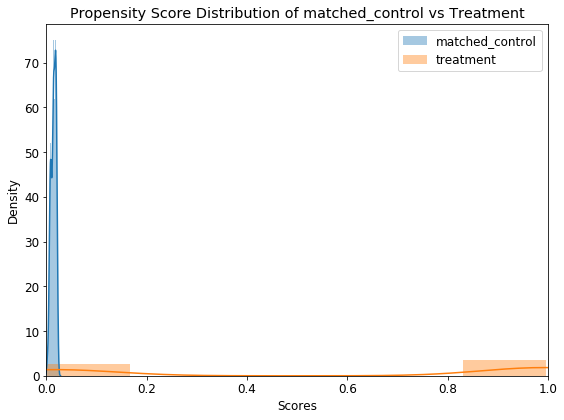

In [65]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(matched_control_df.logit_score, label='matched_control')
sns.distplot(for_mth_df_treated.logit_score, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of matched_control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

#### 2-2-2. Caliper Matching

In [111]:
np.random.seed(10)

def Match(groups, pscore, caliper=0.05):
    '''
    Inputs: 
    groups = indicator to identify control and study group. Must be two groups. Number of treated (study) records should be
            smaller than untreated (control) records.
    pscore = propensity scores for each observation. Groups and pscore must be in the same order (same indices).
    caliper = maximum difference in matched propensity scores.
    '''
    if any(pscore <= 0) or any(pscore >= 1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups) != len(pscore):
        raise ValueError('groups and pscore must have same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
     
    
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); 
    N2 = N - N1;
    g1, g2 = (pscore[groups == 1]),(pscore[groups == 0])
    # N1 is study, N2 is control
    # assuming number of study groups is less than control groups
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1

    if (N1 != len(g1)) or (N2 != len(g2)):
        raise ValueError('Number of study records must be less than control records')

    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN

    for m in morder:
        dist = abs(g1.iloc[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.idxmin()
            g2 = g2.drop(matches[m])
            
    study = pd.DataFrame(g1).reset_index()
    study.columns = ['std_indx', 'std_pscore']
    
#     control = pd.DataFrame(for_mth_df.iloc[matches]['logit_score']).reset_index()
#     control.columns = ['ctl_indx', 'ctl_pscore']
    
#     final_df = study.join(control)

    return matches

In [182]:
# The difference between propensity is within 0.05
matched_idx = Match(for_mth_df.Decorated, for_mth_df.logit_score, caliper = 0.05)
matched_idx.count()

532

In [183]:
caliper_matched_idx =  np.array(matched_idx.dropna()).astype(int)

In [184]:
caliper_matched_control_df = for_mth_df.iloc[caliper_matched_idx]

print(caliper_matched_control_df.shape)
caliper_matched_control_df.head(2)

(532, 16)


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
9273,0.803293,0.250359,-0.305476,-0.228131,-0.226114,0.005024,0,1,0,0,1,0,0.020593,51148609,4.000,4.785714
7429,-2.059970,0.878200,0.066820,0.071469,-0.156071,-0.336946,0,1,0,0,1,0,0.014725,121782694,1.875,2.000000


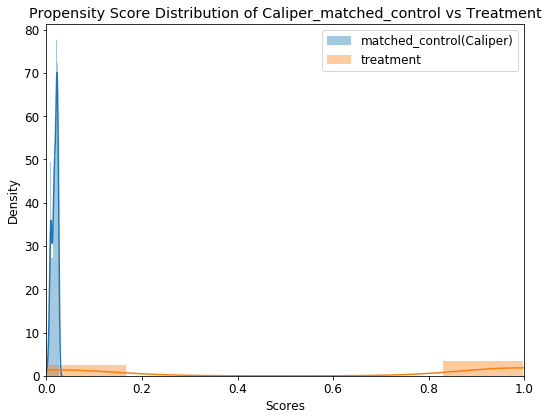

In [185]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(caliper_matched_control_df.logit_score, label='matched_control(Caliper)')
sns.distplot(for_mth_df_treated.logit_score, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Caliper_matched_control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

## Step3. Check overlap and common support

Have been drawed the result after matching

## Step4. Assessing the Matching Quality

### Type4-1. Standardised Bias / Standardized DIfferences

\begin{align}
smd = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{(s^2_t + s^2_c) / 2}}
\end{align}

**Pros:** Doesn't depend on sample size (compared with p-values)<br/>
**Rules of thunb**:<br/>
1.Coursera Version<br/>
- Smaller than $0.1$: Adequate balance; For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
- $0.1$ - $0.2$: Not necessarily balanced, but small enough that people are usually not too worried about them.
- Greater than $0.2$: Values that are greater than this threshold are considered seriously imbalanced.

2.Paper Version<br/>
- A bias reduction below 3% or 5% is seen as sufficient

In [66]:
def assess_balance(trt_df, ctl_df, covariates):
#     trt_df = trt
#     ctl_df = ctl
    t_stat = trt_df[covariates].describe().loc['mean':'std', :].T
    c_stat = ctl_df[covariates].describe().loc['mean':'std', :].T
    assess_df = pd.concat([t_stat.add_prefix('treated_'), c_stat.add_prefix('control_')], axis = 1)
    assess_df['smd'] = abs((assess_df.treated_mean - assess_df.control_mean) / 
                       np.sqrt((assess_df.control_std**2+assess_df.treated_std**2)/2))
    
    return assess_df

In [67]:
# treated.columns.values
covars = ['rating_star', 'display_response_rate', 'sku', 'p30_gmv',
          'p30_order_cnt', 'follower_count'
          , 'seller_type_NS', 'seller_type_OS', 'seller_type_PS', 'camp_flag_N', 'camp_flag_Y'
         ]

#### Control vs Treat - 0.38

In [72]:
assess_detail = assess_balance(for_mth_df_treated, for_mth_df_control, covars)
assess_detail

,treated_mean,treated_std,control_mean,control_std,smd
rating_star,0.097328,0.912437,-0.003520,1.002873,0.105189
display_response_rate,0.288200,0.832961,-0.010422,1.003997,0.323726
sku,-0.065576,0.649433,0.002371,1.010342,0.080005
p30_gmv,0.036356,0.760437,-0.001315,1.007595,0.042203
p30_order_cnt,0.052121,0.895460,-0.001885,1.003552,0.056786
follower_count,0.035862,0.793935,-0.001297,1.006661,0.040989
seller_type_NS,0.781804,0.413188,0.845193,0.361726,0.163244
seller_type_OS,0.011272,0.105613,0.008356,0.091031,0.029577
seller_type_PS,0.206924,0.405264,0.146451,0.353563,0.159018
camp_flag_N,0.428341,0.495038,1.000000,0.000000,1.633103


In [73]:
print('std of treatment and control', assess_detail.smd.mean())

std of treatment and control 0.387903868568007


Since the standarization doesn't change the distribution, the smd after data transformed is as same as before data did.

#### NN Matched Control vs Treat - 0.44

In [74]:
assess_detail_2 = assess_balance(for_mth_df_treated, matched_control_df, covars)
assess_detail_2

,treated_mean,treated_std,control_mean,control_std,smd
rating_star,0.097328,0.912437,-0.136826,0.935953,0.253339
display_response_rate,0.288200,0.832961,-0.076374,0.833062,0.437659
sku,-0.065576,0.649433,0.013276,0.688118,0.117855
p30_gmv,0.036356,0.760437,-0.006596,0.680341,0.059531
p30_order_cnt,0.052121,0.895460,0.008983,0.716659,0.053191
follower_count,0.035862,0.793935,0.031686,0.726326,0.005489
seller_type_NS,0.781804,0.413188,0.896520,0.304724,0.315998
seller_type_OS,0.011272,0.105613,0.011905,0.108507,0.005908
seller_type_PS,0.206924,0.405264,0.091575,0.288557,0.327898
camp_flag_N,0.428341,0.495038,1.000000,0.000000,1.633103


In [75]:
assess_detail_2.smd.mean()

0.4402793603679344

#### Caliper NN Matched Control vs Treat - 0.48

In [180]:
assess_detail_3 = assess_balance(for_mth_df_treated, caliper_matched_control_df, covars)
assess_detail_3

,treated_mean,treated_std,control_mean,control_std,smd
rating_star,0.097328,0.912437,0.196092,0.842556,0.112463
display_response_rate,0.288200,0.832961,0.185149,0.878042,0.120416
sku,-0.065576,0.649433,-0.166111,0.496249,0.173954
p30_gmv,0.036356,0.760437,-0.133424,0.226925,0.302561
p30_order_cnt,0.052121,0.895460,-0.148828,0.279731,0.302925
follower_count,0.035862,0.793935,-0.097958,0.489107,0.202949
seller_type_NS,0.781804,0.413188,0.925121,0.263515,0.413580
seller_type_OS,0.011272,0.105613,0.002415,0.049147,0.107524
seller_type_PS,0.206924,0.405264,0.072464,0.259568,0.395118
camp_flag_N,0.428341,0.495038,1.000000,0.000000,1.633103


In [181]:
assess_detail_3.smd.mean()

0.4906995353780959

### Type4-2. t-Test

In [205]:
# NN Matched Control vs Treat
stat_df = pd.concat([
    matched_control_df[covars].agg(['mean', 'sem']).T.add_prefix('matched_control_'),
    for_mth_df_treated[covars].agg(['mean', 'sem']).T.add_prefix('treat_')
], axis = 1)

In [206]:
stat_df

,matched_control_mean,matched_control_sem,treat_mean,treat_sem
rating_star,-0.136826,0.028323,0.097328,0.025891
display_response_rate,-0.076374,0.025210,0.288200,0.023635
sku,0.013276,0.020823,-0.065576,0.018428
p30_gmv,-0.006596,0.020588,0.036356,0.021578
p30_order_cnt,0.008983,0.021687,0.052121,0.025409
follower_count,0.031686,0.021980,0.035862,0.022528
seller_type_NS,0.896520,0.009221,0.781804,0.011724
seller_type_OS,0.011905,0.003284,0.011272,0.002997
seller_type_PS,0.091575,0.008732,0.206924,0.011499
camp_flag_N,1.000000,0.000000,0.428341,0.014047


In [207]:
for x in stat_df.index.values:
    print("Variable: " + x)
    print(stats.ttest_ind(matched_control_df[x].dropna(),
                          for_mth_df_treated[x].dropna()
                         )
         )

Variable: rating_star
Ttest_indResult(statistic=-6.111938718923056, pvalue=1.1503113189164335e-09)
Variable: display_response_rate
Ttest_indResult(statistic=-10.550153951051831, pvalue=1.8805939176309e-25)
Variable: sku
Ttest_indResult(statistic=2.8462971646552453, pvalue=0.0044617506356128475)
Variable: p30_gmv
Ttest_indResult(statistic=-1.4299556531373372, pvalue=0.15286370561319093)
Variable: p30_order_cnt
Ttest_indResult(statistic=-1.2732805234821494, pvalue=0.2030454222620311)
Variable: follower_count
Ttest_indResult(statistic=-0.13193010069101802, pvalue=0.8950509609677398)
Variable: seller_type_NS
Ttest_indResult(statistic=7.546026578178591, pvalue=6.393524042517375e-14)
Variable: seller_type_OS
Ttest_indResult(statistic=0.14255276868882866, pvalue=0.8866557163353253)
Variable: seller_type_PS
Ttest_indResult(statistic=-7.8223614839547, pvalue=7.790942819984469e-15)
Variable: camp_flag_N
Ttest_indResult(statistic=38.15913527485795, pvalue=5.686114707587068e-248)
Variable: camp_fl

From the p-value, we are hard to say our matching is successful.

## Step5. Calculation of Treatment Effects

In [210]:
matched_control_df.head(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
32378,-0.302968,0.698817,0.127114,-0.126965,-0.090407,0.047065,0,1,0,0,1,0,0.018138,13037,7.750000,2.592593
12676,0.347774,-0.646557,-0.087267,-0.234761,-0.226114,-0.220698,0,1,0,0,1,0,0.013945,122425313,2.166667,1.777778


In [216]:
# The increase of clicks pre user with non-decorated shop
(matched_control_df.Clicks_pre_User_After - matched_control_df.Clicks_pre_User_Before).mean()

-0.022447097964285675

In [211]:
for_mth_df_treated.head(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
33,-0.172819,0.878200,0.013225,-0.242560,-0.258946,-0.066925,1,1,0,0,1,0,0.020593,18109304,10.0,9.8
54,0.542997,-0.646557,-0.208813,-0.241198,-0.254569,-0.241578,1,1,0,0,1,0,0.014725,37819643,4.0,3.2


In [217]:
# The increase of clicks pre user with decorated shop
(for_mth_df_treated.Clicks_pre_User_After - for_mth_df_treated.Clicks_pre_User_Before).mean()

0.1576129063019323

## Step6. Sensitivity Analysis

In [224]:
# sens_df = pd.concat([matched_control_df, for_mth_df_treated])
# sens_df['y'] = sens_df.Clicks_pre_User_After - sens_df.Clicks_pre_User_Before
# sens_df.drop(columns = ['Clicks_pre_User_After', 'Clicks_pre_User_Before'])
# sens_df.sample(2)